# Significance

In [2]:
import xarray as xr
from climpred.tutorial import load_dataset
from climpred.stats import rm_poly
from climpred.prediction import compute_hindcast, compute_perfect_model
from climpred.bootstrap import bootstrap_hindcast, bootstrap_perfect_model
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

In [3]:
# load data
v = "SST"
hind = load_dataset("CESM-DP-SST")[v]
hind.lead.attrs["units"] = "years"

hist = load_dataset("CESM-LE")[v]
hist = hist - hist.mean()

obs = load_dataset("ERSST")[v]
obs = obs - obs.mean()

In [4]:
# align times
hind["init"] = xr.cftime_range(
    start=str(hind.init.min().astype("int").values), periods=hind.init.size, freq="YS"
)
hist["time"] = xr.cftime_range(
    start=str(hist.time.min().astype("int").values), periods=hist.time.size, freq="YS"
)
obs["time"] = xr.cftime_range(
    start=str(obs.time.min().astype("int").values), periods=obs.time.size, freq="YS"
)

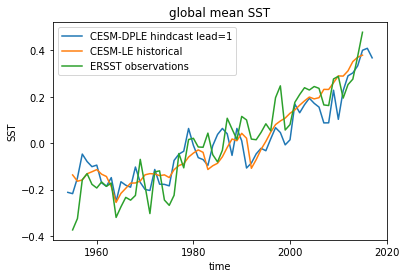

In [5]:
# view the data
hind.sel(lead=1).mean("member").plot(label="CESM-DPLE hindcast lead=1")
hist.mean("member").plot(label="CESM-LE historical")
obs.plot(label="ERSST observations")
plt.legend()
plt.title(f"global mean {v}")
plt.show()

Here we see the strong trend due to climate change. This trend is not linear but rather quadratic. Because we often aim to prediction natural variations and not specifically the external forcing in initialized predictions, we remove the 2nd-order trend from each dataset along a time axis.

In [6]:
order = 2
hind = rm_poly(hind, dim="init", order=order)
hist = rm_poly(hist, dim="time", order=order)
obs = rm_poly(obs, dim="time", order=order)
# lead attrs is lost in rm_poly
hind.lead.attrs["units"] = "years"

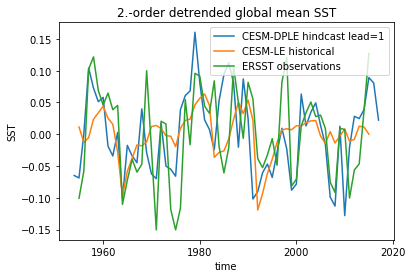

In [7]:
hind.sel(lead=1).mean("member").plot(label="CESM-DPLE hindcast lead=1")
hist.mean("member").plot(label="CESM-LE historical")
obs.plot(label="ERSST observations")
plt.legend()
plt.title(f"{order}.-order detrended global mean {v}")
plt.show()

## Metric-based p-value
For correlation metrics the associated p-value checks whether the correlation 
is significantly different from zero incorporating reduced degrees of freedom 
due to temporal autocorrelation.

In [8]:
# level that initialized ensembles are significantly better than other forecast skills
sig = 0.05

In [9]:
acc = compute_hindcast(hind, obs, metric="pearson_r", comparison="e2r")

acc_p_value = compute_hindcast(hind, obs, metric="pearson_r_p_value", comparison="e2r")

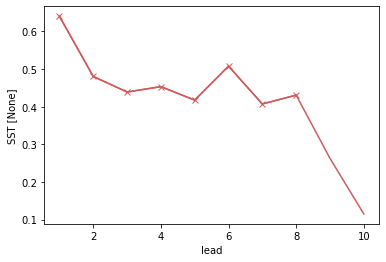

In [10]:
init_color = "indianred"
acc.plot(c=init_color)
acc.where(acc_p_value <= sig).plot(marker="x", c=init_color)

## Bootstrapping with replacement

Bootstrapping significance relies of resampling the underlying data with replacement of
large number of iterations as proposed by the decadal prediction framework of Goddard
et al. 2013.

In [11]:
bootstrapped_acc = bootstrap_hindcast(
    hind, hist, obs, metric="pearson_r", comparison="e2r", bootstrap=10
)

In [12]:
# all
bootstrapped_acc.coords

Coordinates:
  * kind     (kind) object 'init' 'pers' 'uninit'
  * lead     (lead) int64 1 2 3 4 5 6 7 8 9 10
  * results  (results) <U7 'skill' 'p' 'low_ci' 'high_ci'

In [13]:
init_skill = bootstrapped_acc.sel(results="skill", kind="init")
init_better_than_uninit = init_skill.where(
    bootstrapped_acc.sel(results="p", kind="uninit") <= sig
)
init_better_than_persistence = init_skill.where(
    bootstrapped_acc.sel(results="p", kind="pers") <= sig
)

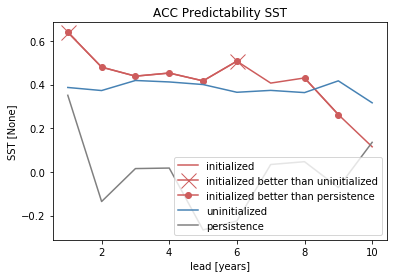

In [14]:
# create a plot by hand
bootstrapped_acc.sel(results="skill", kind="init").plot(
    c=init_color, label="initialized"
)
init_better_than_uninit.plot(
    c=init_color,
    marker="x",
    markersize=15,
    label="initialized better than uninitialized",
)
init_better_than_persistence.plot(
    c=init_color, marker="o", label="initialized better than persistence"
)
bootstrapped_acc.sel(results="skill", kind="uninit").plot(
    c="steelblue", label="uninitialized"
)
bootstrapped_acc.sel(results="skill", kind="pers").plot(c="gray", label="persistence")
plt.title(f"ACC Predictability {v}")
plt.legend(loc="lower right")

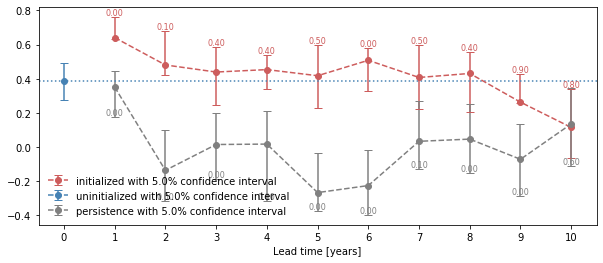

In [15]:
# use climpred convenience plotting function
from climpred.graphics import plot_bootstrapped_skill_over_leadyear

plot_bootstrapped_skill_over_leadyear(bootstrapped_acc, sig * 100)

## Field significance

Using `esmtools.testing.multipletests` to control the false discovery
rate (FDR) from the above obtained p-values in geospatial data.

In [16]:
v = "tos"
ds3d = load_dataset("MPI-PM-DP-3D")[v]
ds3d.lead.attrs["unit"] = "years"
control3d = load_dataset("MPI-control-3D")[v]

### Metric-based p-values

In [17]:
# ACC skill
acc3d = compute_perfect_model(ds3d, control3d, metric="pearson_r", comparison="m2e")

# ACC_p_value skill
acc_p_3d = compute_perfect_model(
    ds3d, control3d, metric="pearson_r_p_value", comparison="m2e"
)

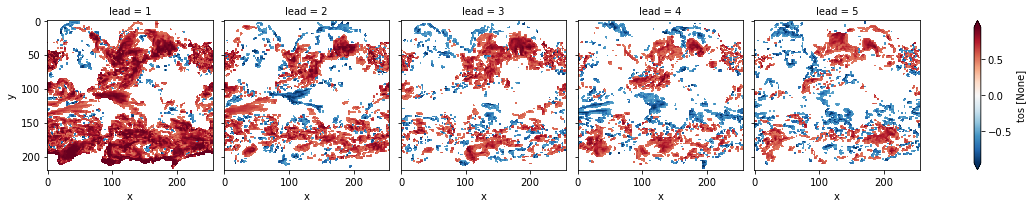

In [18]:
# mask init skill where not significant
acc3d.where(acc_p_3d <= sig).plot(col="lead", robust=True, yincrease=False)

In [19]:
# apply FDR Benjamini-Hochberg
# relies on esmtools https://github.com/bradyrx/esmtools
from esmtools.testing import multipletests

_, acc_p_3d_fdr_corr = multipletests(acc_p_3d, method="fdr_bh", alpha=sig)

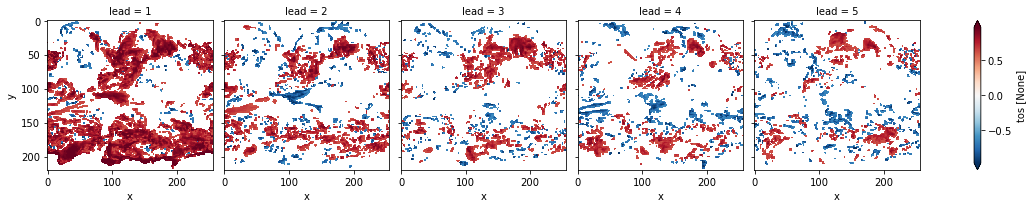

In [20]:
# mask init skill where not significant on corrected p-values
acc3d.where(acc_p_3d_fdr_corr <= sig).plot(col="lead", robust=True, yincrease=False)

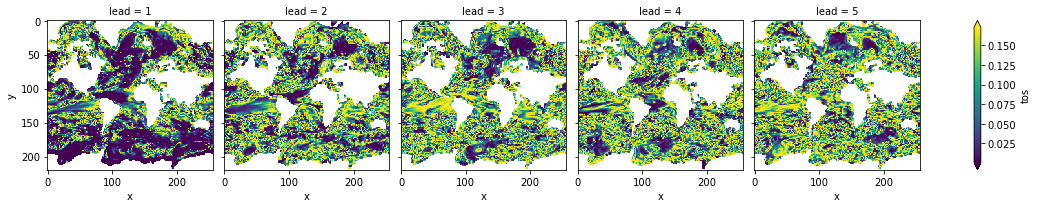

In [21]:
# difference due to FDR Benjamini-Hochberg
(acc_p_3d_fdr_corr - acc_p_3d).plot(col="lead", robust=True, yincrease=False)

FDR Benjamini-Hochberg increases the p-value and therefore reduces the number of significant grid cells.

### Bootstrapping with replacement

In [22]:
bootstrapped_acc_3d = bootstrap_perfect_model(
    ds3d, control3d, metric="pearson_r", comparison="m2e", bootstrap=10
)

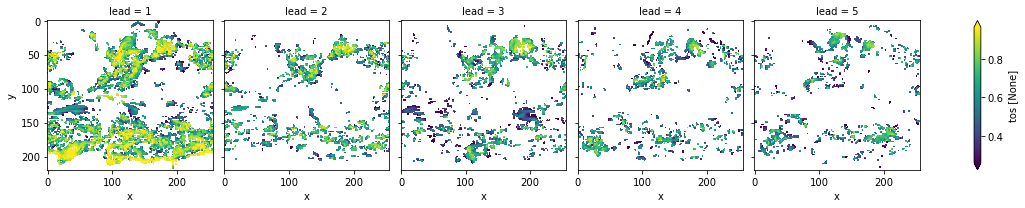

In [23]:
# mask init skill where not significant
bootstrapped_acc_3d.sel(kind="init", results="skill").where(
    bootstrapped_acc_3d.sel(kind="uninit", results="p") <= sig
).plot(col="lead", robust=True, yincrease=False)

In [24]:
# apply FDR Benjamini-Hochberg
_, bootstrapped_acc_p_3d_fdr_corr = multipletests(
    bootstrapped_acc_3d.sel(kind="uninit", results="p"), method="fdr_bh", alpha=sig
)

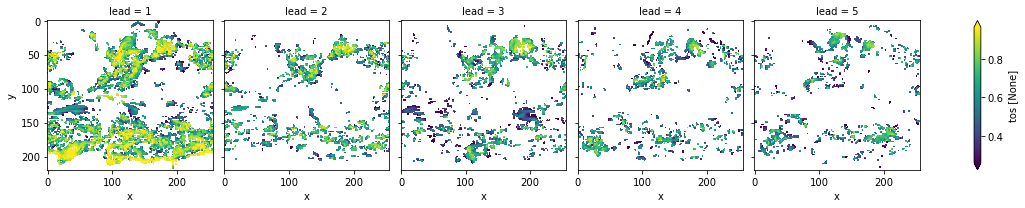

In [25]:
# mask init skill where not significant on corrected p-values
bootstrapped_acc_3d.sel(kind="init", results="skill").where(
    bootstrapped_acc_p_3d_fdr_corr <= sig
).plot(col="lead", robust=True, yincrease=False)

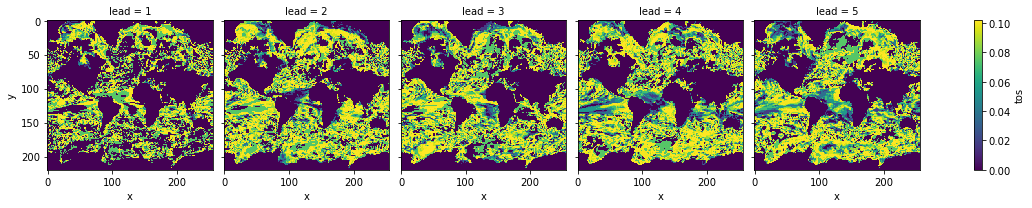

In [26]:
# difference due to FDR Benjamini-Hochberg
(
    bootstrapped_acc_p_3d_fdr_corr - bootstrapped_acc_3d.sel(kind="uninit", results="p")
).plot(col="lead", robust=True, yincrease=False)

FDR Benjamini-Hochberg increases the p-value and therefore reduces the number of significant grid cells.